In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## load data
path = '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/ADSP_vcf/phenotype_file/release_36K/'
ADNI = pd.read_csv(path + "ADNIPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
family_based = pd.read_csv(path + "ADSPFamilyBasedPhenotypes_DS_2022.08.18_ALL.txt", sep='\t',encoding='cp1252')
case_control = pd.read_csv(path + "ADSPCaseControlPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
PSPCBD = pd.read_csv(path + "PSPCBDPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
SUBJ_drop = pd.read_excel(path + 'ng00067_subject_droplist_2022.08.18.xlsx', engine = 'openpyxl')
PSPCBD_descript = pd.read_excel(path + 'PSPCBDPhenotypes_DD_2022.08.18.xlsx', engine = 'openpyxl')
vcf = pd.read_csv(path + 'vcf_ids.txt', sep = '\t')
manifest = pd.read_csv(path + "SampleManifest_DS_2022.08.18_ALL.txt", sep='\t') ## the one with mapping info

qc = pd.read_csv(path+"gcad.qc.r4.wgs.allchr.36361.GATK.2022.08.15.sample.summary.ALL.txt", sep = '\t') ## this one contains QC info( all the sampleID here are WGS)
ibd = pd.read_csv(path + 'gcad.r4.wgs.36361.2022.08.15.pairwise_IBD.txt', sep = '\t')

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
## SUBJID and SampleID are not 1-1 match
print(len(manifest.SUBJID.unique()))
print(len(manifest.SampleID.unique()))

51992
56863


## deal with pheno_merge

In [4]:
print(ADNI.shape, family_based.shape, case_control.shape, PSPCBD.shape)

(1566, 31) (12858, 27) (45375, 31) (2803, 17)


In [43]:
print(ADNI.columns)
print(family_based.columns)
print(case_control.columns)
print(PSPCBD.columns)

Index(['SUBJID', 'Sex', 'PrevAD', 'IncAD', 'Age_current', 'Age_baseline',
       'Age_MCI_onset', 'Age_AD_onset', 'APOE_reported', 'APOE_WGS', 'AUTOPSY',
       'Braak', 'Race', 'Ethnicity', 'AD_last_visit', 'MCI_last_visit',
       'Duplicate_SUBJID', 'Comments', 'Latest_Update_Version', 'Base_PrevAD',
       'Base_IncAD', 'Base_Age', 'Base_AUTOPSY', 'Base_Braak', 'Base_AD',
       'Base_MCI', 'Base_Version', 'Update_baseline', 'Update_latest',
       'Update_Diagnosis', 'Correction'],
      dtype='object')
Index(['SUBJID', 'FamID', 'Father', 'Mother', 'Sex', 'AD', 'Age',
       'Age_baseline', 'APOE_reported', 'APOE_WGS', 'AUTOPSY', 'Braak', 'Race',
       'Ethnicity', 'FamGrp', 'Comments', 'Duplicate_SUBJID',
       'Latest_Update_Version', 'Base_AD', 'Base_Age', 'Base_AUTOPSY',
       'Base_Braak', 'Base_Version', 'Update_baseline', 'Update_latest',
       'Update_ADstatus', 'Correction'],
      dtype='object')
Index(['SUBJID', 'Sex', 'PrevAD', 'IncAD', 'Age', 'Age_baseline',
     

In [22]:
ADNI_processed = ADNI.loc[:,['SUBJID', 'Sex', 'PrevAD', 'IncAD','Age_current', 'Age_MCI_onset','Age_AD_onset', 'Age_baseline','APOE_reported','Race', 'AD_last_visit', 'Ethnicity']]
ADNI_processed["Diagnosis"] = ADNI_processed.AD_last_visit

In [23]:
#ADNI_processed.loc[(ADNI_processed["Age_MCI_onset"].notnull())& (ADNI_processed["Diagnosis"] ==0)]  #528
#ADNI_processed = ADNI_processed.drop(ADNI_processed[(ADNI_processed["Age_MCI_onset"].notnull()) & (ADNI_processed["Diagnosis"] == 0)].index)

ADNI_processed["Age"] = ADNI_processed.Age_current
ADNI_processed.loc[ADNI_processed.Diagnosis == 1,'Age'] = ADNI_processed.loc[ADNI_processed.Diagnosis == 1,'Age_AD_onset']  ## changed the age to age of onset of they are AD cases

In [24]:
print(ADNI_processed.value_counts('Diagnosis'))
ADNI_processed.shape

Diagnosis
0    958
1    608
dtype: int64


(1566, 14)

In [27]:
## There are two cases without age of onset
## all controls have current age and the age they first entered the study!
ADNI_processed[ADNI_processed.Age.isnull()]

,SUBJID,Sex,PrevAD,IncAD,Age_current,Age_MCI_onset,Age_AD_onset,Age_baseline,APOE_reported,Race,AD_last_visit,Ethnicity,Diagnosis,Age
871,G-ADNI-AN000064,0,0,1,66,60,NaN,61,33,5.0,1,0.0,1,NaN
975,G-ADNI-AN000170,0,0,1,76,71,NaN,73,34,5.0,1,0.0,1,NaN


In [30]:
## family_based
family_based['Diagnosis'] = 'NaN'
family_based.loc[family_based['AD'] == 0, "Diagnosis"] = 0
family_based.loc[(family_based['AD'] >=1) & (family_based['AD'] <=3), "Diagnosis"] =1
family_based.Diagnosis.value_counts()

NaN    8507
0      2493
1      1858
Name: Diagnosis, dtype: int64

In [8]:
## family_based (old)
family_based = pd.concat([control,case])
#family_based_processed = family_based.loc[:, ["SUBJID", "Sex", "Diagnosis", "APOE_reported","Age","Race", "Age_baseline"]]
print(family_based_processed.shape)

(6624, 7)


In [40]:
## case_control
#case_control_processed = case_control.loc[:,["SUBJID", "Sex", "AD", "APOE_reported","Age","Race", "Age_baseline"]]
case_control.AD = case_control.AD.astype('Int64')
case_control_processed = case_control.rename(columns = {'AD':'Diagnosis'})
print(case_control_processed.Diagnosis.isna().sum())
print(case_control_processed.Diagnosis.value_counts(dropna=False))
#case_control_processed = case_control_processed.dropna(subset = ['Diagnosis','Age', 'APOE_reported', 'Race'])

5235
0      23347
1      16793
NaN     5235
Name: Diagnosis, dtype: Int64


In [41]:
ADNI_processed["source"] = 'ADNI'
family_based["source"] = 'Family_based'
case_control_processed["source"] = 'case_control'

In [212]:
pheno = pd.concat([ADNI_processed, family_based, case_control_processed])
pheno.loc[pheno['Age'] == '90+', 'Age'] = 90
pheno.loc[pheno['Age_baseline'] == '90+', 'Age_baseline'] = 90
#pheno.Age = pheno.Age.astype('int')
print(pheno.shape)

(59799, 43)


In [214]:
## Only keep WGS
wgs_SUBJID = manifest[manifest.SampleID.isin(qc.SampleID)].SUBJID
wgs_SUBJID.shape

print('before extracting WGS', pheno.shape)
pheno = pheno[pheno.SUBJID.isin(wgs_SUBJID)]

print('After extracting WGS', pheno.shape)

before extracting WGS (59793, 43)
After extracting WGS (33633, 43)


In [215]:
## drop technique replicates (using SUBJID)
replicate_to_drop = manifest[(manifest.SampleID.isin(qc.SampleID)) & (manifest.Technical_Replicate == 1)] ##(63,10)
pheno[pheno.SUBJID.isin(replicate_to_drop.SUBJID)]
pheno = pheno[~pheno.SUBJID.isin(replicate_to_drop.SUBJID)]
#pheno.to_csv(path + 'check_pheno.tsv',sep = '\t', index = False)
pheno.shape

(33633, 43)

In [216]:
duplicated_ID = pheno[pheno.SUBJID.duplicated()].SUBJID
print(duplicated_ID.shape, pheno.shape)

## The duplicates are between family based and case control, two as a pair
print(min(pheno[pheno.SUBJID.isin(duplicated_ID)].value_counts('SUBJID')))
print(max(pheno[pheno.SUBJID.isin(duplicated_ID)].value_counts('SUBJID')))

duplicates = pheno[pheno.SUBJID.isin(duplicated_ID)].sort_values('SUBJID', ascending = False)
print(pheno[pheno.SUBJID.duplicated()].source.unique()) ### they are all case_control
pheno = pheno[~pheno.SUBJID.duplicated()] ## only keep the family_based one
print(pheno.shape)

(32,) (33633, 43)
2
2
['case_control']
(33601, 43)


In [217]:
print(len(pheno.SUBJID.unique()))
print(pheno.Diagnosis.value_counts())
#pheno = pheno[["SUBJID", "Sex", "Diagnosis", "APOE_reported","Age","Race","Ethnicity","FamID",'source']]

33601
0      17386
1      11561
NaN       98
Name: Diagnosis, dtype: int64


<AxesSubplot:title={'center':'data surce for pheno_merge'}>

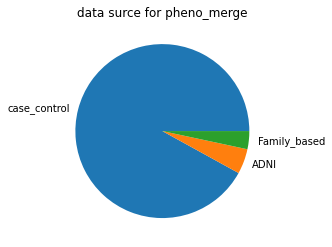

In [117]:
pheno.source.value_counts().plot(kind='pie', ylabel='', title='data surce for pheno_merge')


## manifest & IBD & QC

In [86]:
 ## every SampleID is unique, and they might map to the same SUBJID
print(manifest.shape)
print(len(manifest.SUBJID.unique()))
print(len(manifest.SampleID.unique()))

(56863, 10)
51992
56863


In [119]:
## Manifest
pheno_add_SampleID  = pheno.merge(manifest, on="SUBJID")
print(pheno_add_SampleID.shape)
dup_sample = pheno_add_SampleID[pheno_add_SampleID.SUBJID.duplicated(keep=False)] #9033 row

dup_SampleID = manifest[manifest.SUBJID.isin(dup_sample.SUBJID.unique())].SampleID ##9033
print(qc[qc.SampleID.isin(dup_SampleID)].Missing.idxmin())
dup_SampleID[~dup_SampleID.isin(qc.SampleID)]  ## not every SampleID is found in QC file

## extract the SampleID with the lowest missing num
best_SampleID=[]
for i in dup_sample.SUBJID.unique():
    SampleID = manifest[manifest.SUBJID==i].SampleID
    best_id = qc[qc.SampleID.isin(SampleID)].Missing.idxmin()
    best_SampleID.append(qc.loc[best_id].SampleID)
    

(38133, 18)
22552


In [121]:
print(len(best_SampleID))
print(len(dup_sample.SUBJID.unique()))

4501

In [126]:
map_sampleID = dict(list(zip(dup_sample.SUBJID.unique(), best_SampleID)))

In [152]:
pheno_SampleID_todrop = pheno_add_SampleID[pheno_add_SampleID.SUBJID.isin(map_sampleID)]

In [154]:
pheno_SampleID_todrop[pheno_SampleID_todrop.SampleID != pheno_SampleID_todrop.SUBJID.map(map_sampleID)]

,SUBJID,Sex,Diagnosis,APOE_reported,Age,Race,Ethnicity,FamID,source,SampleID,BODY_SITE,ANALYTE_TYPE,Sequencing_Center,Sequencing_Platform,SAMPLE_USE,Technical_Replicate,Study_DSS,Sample_Set
1973,A-CUHS-CU006133,1.0,0,44.0,58,6.0,1.0,CU0098F,Family_based,A-CUHS-CU006133-BL-COL-31008BL1,Blood,DNA,WashU,Illumina_HiSeqX,WGS,0,sa000001,snd10001
2001,A-LOAD-LD001135,1.0,1,33.0,74,5.0,0.0,LD0191F,Family_based,A-LOAD-LD001135-BL-NCR-8008285337,Blood,DNA,Otogenetics,Illumina_HiSeq_2000,WES,0,sa000004,snd10004
2016,A-LOAD-LD001340,1.0,1,23.0,70,5.0,0.0,LD0241F,Family_based,A-LOAD-LD001340-CL-NCR-07AD1620,Cell Line,DNA,UW_GenomeSciences,Illumina_HiSeq_2000,WES,0,sa000005,snd10005
2020,A-LOAD-LD001349,1.0,1,33.0,85,5.0,0.0,LD0241F,Family_based,A-LOAD-LD001349-UNK-NCR-11AD47531,Unknown,DNA,UW_GenomeSciences,Illumina_HiSeq_2000,WES,0,sa000005,snd10005
2068,A-LOAD-LD004376,0.0,1,33.0,65,5.0,0.0,LD0949F,Family_based,A-LOAD-LD004376-UNK-UNK-UNK0036,Unknown,DNA,GENENTECH,Illumina_HiSeq_2000,WGS,0,sa000004,snd10018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35045,G-KGAD-KA001216,1.0,1,34.0,64,5.0,NaN,NaN,case_control,G-KGAD-KA000886-BL-WU-8038741275,Blood,DNA,USUHS,Illumina_NovaSeq,WGS,0,sa000023,snd10032
37811,G-MSBB-MB000022,0.0,0,NaN,84,5.0,0.0,NaN,case_control,G-MSBB-MB000022-BR-MSBB-71813,Brain,DNA,NYGC,Illumina_HiSeqX,WGS,0,sa000011,snd10011
37884,G-MSBB-MB000094,1.0,1,NaN,82,5.0,0.0,NaN,case_control,G-MSBB-MB000094-BR-MSBB-71738,Brain,DNA,NYGC,Illumina_HiSeqX,WGS,0,sa000011,snd10011
37917,G-MSBB-MB000126,1.0,1,NaN,90,5.0,0.0,NaN,case_control,G-MSBB-MB000126-BR-MSBB-71926,Brain,DNA,NYGC,Illumina_HiSeqX,WGS,0,sa000011,snd10011


In [156]:
pheno_add_SampleID = pheno_add_SampleID.drop(pheno_SampleID_todrop[pheno_SampleID_todrop.SampleID != pheno_SampleID_todrop.SUBJID.map(map_sampleID)].index)  ## get back to 33601

In [157]:
pheno_add_SampleID.shape

(33601, 18)

In [158]:
pheno_add_SampleID.to_csv(path +'check_pheno.tsv',sep = '\t', index = False)

## check King

In [159]:
#king_manifest = pd.read_csv(path+'pheno_merge_sampleID_king.tsv', sep = '\t')
king = np.loadtxt("/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/ADSP_vcf/phenotype_file/release_36K/unrelated_samples.txt", dtype=str) ## The non-related individual's sample ID calculate from Kinship only have sample I

In [165]:
pheno_king = pheno_add_SampleID[pheno_add_SampleID.SampleID.isin(king)] ## 31351

,SUBJID,Sex,Diagnosis,APOE_reported,Age,Race,Ethnicity,FamID,source,SampleID,BODY_SITE,ANALYTE_TYPE,Sequencing_Center,Sequencing_Platform,SAMPLE_USE,Technical_Replicate,Study_DSS,Sample_Set
1,ADNI_002_S_0685,1.0,0,33.0,90,5.0,0.0,NaN,ADNI,ADNI_002_S_0685,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
3,ADNI_002_S_1155,0.0,0,33.0,69,5.0,0.0,NaN,ADNI,ADNI_002_S_1155,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
4,ADNI_002_S_1261,1.0,0,33.0,82,5.0,0.0,NaN,ADNI,ADNI_002_S_1261,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
7,ADNI_002_S_2010,1.0,0,34.0,68,6.0,0.0,NaN,ADNI,ADNI_002_S_2010,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
9,ADNI_002_S_2073,1.0,0,33.0,69,5.0,0.0,NaN,ADNI,ADNI_002_S_2073,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38128,G-MSBB-MB000337,1.0,0,NaN,62,4.0,0.0,NaN,case_control,G-MSBB-MB000337-BR-MSBB-76349,Brain,DNA,NYGC,Illumina_HiSeqX,WGS,0,sa000011,snd10011
38129,G-MSBB-MB000338,1.0,1,NaN,90,5.0,0.0,NaN,case_control,G-MSBB-MB000338-BR-MSBB-76350,Brain,DNA,NYGC,Illumina_HiSeqX,WGS,0,sa000011,snd10011
38130,G-MSBB-MB000339,1.0,1,NaN,90,5.0,0.0,NaN,case_control,G-MSBB-MB000339-BR-MSBB-76351,Brain,DNA,NYGC,Illumina_HiSeqX,WGS,0,sa000011,snd10011
38131,G-MSBB-MB000340,0.0,1,NaN,82,5.0,0.0,NaN,case_control,G-MSBB-MB000340-BR-MSBB-76352,Brain,DNA,NYGC,Illumina_HiSeqX,WGS,0,sa000011,snd10011


In [181]:
pheno_king['source'].value_counts()

case_control    29410
ADNI             1378
Family_based      563
Name: source, dtype: int64

In [193]:

# Convert 'Diagnosis' column to string data type
pheno_king['Diagnosis'] =pheno_king['Diagnosis'].astype(str)

family = pheno_king[pheno_king.source=='Family_based']  ## they have 1114, we have 563

# Randomly shuffle the rows of the DataFrame
families = family.sample(frac=1)

# Sort the DataFrame by 'Diagnosis' column, group by 'FamID', select the first row in each group, and reset the index
one_per_fam = families.sort_values(by='Diagnosis', ascending=False)\
                     .groupby('FamID', sort=False)\
                     .head(1)\
                     .reset_index(drop=True)


/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [194]:
pheno_fin = pd.concat([pheno_king[pheno_king.source!='Family_based'],one_per_fam])

In [195]:
pheno_fin.shape

(31049, 18)

In [196]:
pheno_fin["Diagnosis"].value_counts()

0       16155
1       10571
<NA>     4286
NaN        37
Name: Diagnosis, dtype: int64

In [207]:
pheno_fin = pheno_fin[(pheno_fin.Diagnosis == '1' ) | (pheno_fin.Diagnosis == '0' )] ## 26726, remove the NAs

In [211]:
Age_null = pheno_fin[pheno_fin['Age'].isnull()].SUBJID

In [221]:
Age_null.shape

(673,)

In [225]:
print(pheno[pheno.SUBJID.isin(Age_null)].Age_current.isnull().sum())
pheno.loc[pheno.SUBJID.isin(Age_null),["source",'Age_current','Diagnosis','SUBJID']]


672


,source,Age_current,Diagnosis,SUBJID
871,ADNI,66,1,G-ADNI-AN000064
12244,Family_based,NaN,0,A-RAS-RA000188
1441,case_control,NaN,1,A-ADC-AD000091
1462,case_control,NaN,1,A-ADC-AD000125
1465,case_control,NaN,1,A-ADC-AD000132
...,...,...,...,...
42347,case_control,NaN,0,G-KGAD-KA001271
42348,case_control,NaN,0,G-KGAD-KA001272
42349,case_control,NaN,0,G-KGAD-KA001273
42350,case_control,NaN,0,G-KGAD-KA001274


In [228]:
pheno_fin.loc[pheno_fin.SUBJID == 'G-ADNI-AN000064','Age'] = 66

In [232]:
pheno_fin = pheno_fin.dropna(subset=['Age']) ##26054
pheno_fin = pheno_fin[['SUBJID','SampleID', 'Sex', 'Diagnosis', 'APOE_reported', 'Age', 'Race',
       'Ethnicity', 'FamID', 'source']]

In [240]:
pheno_fin.to_csv(path +'pheno_fin.tsv',sep = '\t', index = False) 

In [235]:
pheno_fin.columns

Index(['SUBJID', 'Sex', 'Diagnosis', 'APOE_reported', 'Age', 'Race',
       'Ethnicity', 'FamID', 'source', 'SampleID', 'BODY_SITE', 'ANALYTE_TYPE',
       'Sequencing_Center', 'Sequencing_Platform', 'SAMPLE_USE',
       'Technical_Replicate', 'Study_DSS', 'Sample_Set'],
      dtype='object')

In [87]:
### Deal with IBD
## mapping SampleID to SUBJID
ibdpair_95 = ibd[ibd.PI_HAT>.95]
mapping = manifest.loc[(manifest['SampleID'].isin(ibdpair_95.SampleID1)) | (manifest['SampleID'].isin(ibdpair_95.SampleID2)),['SUBJID','SampleID']]
map_dict = dict(list(zip(mapping.SampleID, mapping.SUBJID)))

ibdpair_95[ibdpair_95.SampleID1.isin(manifest.SampleID)] ## all are found

## Add SUBJID to IBD pair
ibdpair_95.loc[:,['SUBJID1']] = ibdpair_95['SampleID1'].map(map_dict)
ibdpair_95.loc[:,['SUBJID2']] = ibdpair_95['SampleID2'].map(map_dict)

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
